<a href="https://colab.research.google.com/github/hybridkris/hybridkris-biosignature-ai-project/blob/main/01_clean_biosignature_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install biopython astroquery pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 47.9 MB/s eta 0:00:00


In [12]:
import pandas as pd

# Example dataset of extremophiles
extremophiles = [
    {"organism": "Thermus thermophilus", "is_hot_adapted": 1, "is_cold_adapted": 0},
    {"organism": "Pyrococcus furiosus", "is_hot_adapted": 1, "is_cold_adapted": 0},
    {"organism": "Psychrobacter arcticus", "is_hot_adapted": 0, "is_cold_adapted": 1},
    {"organism": "Colwellia psychrerythraea", "is_hot_adapted": 0, "is_cold_adapted": 1},
    {"organism": "Halobacterium salinarum", "is_hot_adapted": 1, "is_cold_adapted": 0}
]

genome_df = pd.DataFrame(extremophiles)
genome_df

,organism,is_hot_adapted,is_cold_adapted
0,Thermus thermophilus,1,0
1,Pyrococcus furiosus,1,0
2,Psychrobacter arcticus,0,1
3,Colwellia psychrerythraea,0,1
4,Halobacterium salinarum,1,0


In [13]:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive

# Pull planets with temp, radius, and mass
planets = NasaExoplanetArchive.query_criteria(
    table="pscomppars",
    select="pl_name,pl_eqt,pl_rade,pl_masse",
    where="pl_eqt IS NOT NULL and pl_rade IS NOT NULL and pl_masse IS NOT NULL",
    order="pl_eqt"
)

planet_df = planets.to_pandas()
planet_df = planet_df.rename(columns={
    'pl_name': 'planet_name',
    'pl_eqt': 'equilibrium_temp',
    'pl_rade': 'radius_Earth',
    'pl_masse': 'mass_Earth'
})
planet_df = planet_df.dropna().reset_index(drop=True)
planet_df.head()

<ipython-input-13-10ce39679a02>:1: DeprecationWarning: the ``nasa_exoplanet_archive`` module has been moved to astroquery.ipac.nexsci.nasa_exoplanet_archive, please update your imports.
  from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive


,planet_name,equilibrium_temp,radius_Earth,mass_Earth
0,MOA-2007-BLG-400L b,34.0,13.50,540.308292
1,OGLE-2005-BLG-390L b,50.0,2.21,5.500000
2,OGLE-2005-BLG-071L b,55.0,13.00,1200.000000
3,OGLE-2006-BLG-109L c,59.0,11.10,86.000000
4,OGLE-2006-BLG-109L b,82.0,14.00,231.000000


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
planet_df[["equilibrium_temp", "radius_Earth", "mass_Earth"]] = scaler.fit_transform(
    planet_df[["equilibrium_temp", "radius_Earth", "mass_Earth"]]
)
planet_df.head()

,planet_name,equilibrium_temp,radius_Earth,mass_Earth
0,MOA-2007-BLG-400L b,-1.929692,0.871557,0.070689
1,OGLE-2005-BLG-390L b,-1.900611,-1.013943,-0.404791
2,OGLE-2005-BLG-071L b,-1.891524,0.788054,0.657198
3,OGLE-2006-BLG-109L c,-1.884254,0.470742,-0.333221
4,OGLE-2006-BLG-109L b,-1.842450,0.955060,-0.204307


In [15]:
import numpy as np

training_data = []

for _, genome in genome_df.iterrows():
    for _, planet in planet_df.iterrows():
        label = 0
        if genome["is_hot_adapted"] and planet["equilibrium_temp"] > 0:
            label = 1
        elif genome["is_cold_adapted"] and planet["equilibrium_temp"] < 0:
            label = 1

        features = [
            genome["is_hot_adapted"],
            genome["is_cold_adapted"],
            planet["equilibrium_temp"],
            planet["radius_Earth"],
            planet["mass_Earth"]
        ]
        training_data.append((features, label))

X = np.array([x for x, _ in training_data])
y = np.array([y for _, y in training_data])

# Sanity check
print("Label counts:", dict(zip(*np.unique(y, return_counts=True))))

Label counts: {np.int64(0): np.int64(3822), np.int64(1): np.int64(3668)}


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       793
           1       0.60      0.56      0.58       705

    accuracy                           0.62      1498
   macro avg       0.62      0.62      0.62      1498
weighted avg       0.62      0.62      0.62      1498



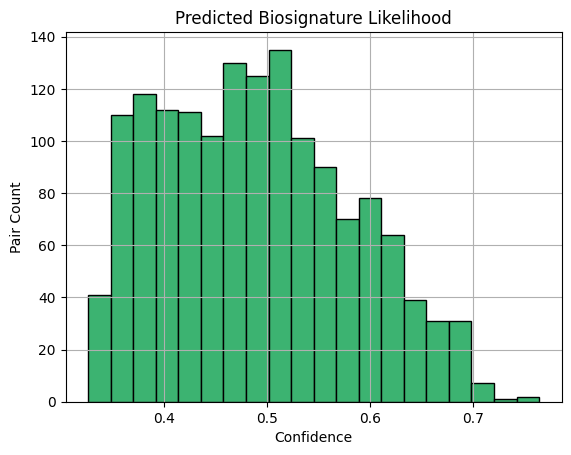

In [17]:
import matplotlib.pyplot as plt

probs = model.predict_proba(X_test)[:, 1]
plt.hist(probs, bins=20, color="mediumseagreen", edgecolor="black")
plt.title("Predicted Biosignature Likelihood")
plt.xlabel("Confidence")
plt.ylabel("Pair Count")
plt.grid(True)
plt.show()

In [18]:
!pip install ncbi-datasets-pylib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 12.5 MB/s eta 0:00:00
  Created wheel for ncbi-datasets-pylib: fi

In [1]:
!curl -sSL https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/v2/linux-amd64/datasets > datasets
!chmod +x datasets
!./datasets version

datasets version: 17.3.0


In [2]:
!./datasets summary genome taxon "Thermus thermophilus" --as-json-lines > thermus.jsonl

In [3]:
import pandas as pd
import json

records = []
with open("thermus.jsonl", "r") as f:
    for line in f:
        genome = json.loads(line)
        # Check if 'assembly' key exists before accessing it
        assembly_data = genome.get("assembly", {})
        records.append({
            "organism": genome["organism"].get("organism_name", ""),
            "accession": assembly_data.get("accession", ""), # Use assembly_data here
            "genome_size": genome.get("assembly_stats", {}).get("total_sequence_length", None),
            "gc_content": genome.get("assembly_stats", {}).get("gc_percent", None),
            "description": genome.get("assembly", {}).get("display_name", "") #Handle missing 'assembly'

        })

genome_df = pd.DataFrame(records)
print(genome_df.head())

               organism accession genome_size  gc_content description
0  Thermus thermophilus               2140665        69.0            
1  Thermus thermophilus               2111307        69.5            
2  Thermus thermophilus               2123574        69.5            
3  Thermus thermophilus               2035606        69.5            
4  Thermus thermophilus               2144289        69.0            


In [4]:
# Just print the raw JSON of the first record to debug structure
with open("thermus.jsonl", "r") as f:
    first = json.loads(next(f))
    print(json.dumps(first, indent=2))

{
  "accession": "GCF_002355995.1",
  "annotation_info": {
    "method": "Best-placed reference protein set; GeneMarkS-2+",
    "name": "NCBI Prokaryotic Genome Annotation Pipeline (PGAP)",
    "pipeline": "NCBI Prokaryotic Genome Annotation Pipeline (PGAP)",
    "provider": "NCBI RefSeq",
    "release_date": "2020-06-05",
    "software_version": "4.11",
    "stats": {
      "gene_counts": {
        "non_coding": 56,
        "protein_coding": 1806,
        "pseudogene": 457,
        "total": 2319
      }
    }
  },
  "assembly_info": {
    "assembly_level": "Complete Genome",
    "assembly_method": "FALCON v. 0.4.0",
    "assembly_name": "ASM235599v1",
    "assembly_status": "suppressed",
    "assembly_type": "haploid",
    "bioproject_accession": "PRJDB5285",
    "bioproject_lineage": [
      {
        "bioprojects": [
          {
            "accession": "PRJDB5285",
            "title": "Complete genome sequence of Thermus thermophilus TMY"
          }
        ]
      }
    ],
    "

In [5]:
def extract_features(genome):
    organism = genome["organism"].get("organism_name", "")
    assembly = genome.get("assembly", {})
    stats = genome.get("assembly_stats", {})
    bioattrs = {a["name"]: a["value"] for a in assembly.get("biosample", {}).get("attributes", [])}

    # Define flags based on keywords
    env = bioattrs.get("env_local_scale", "").lower()
    is_hot = int("geothermal" in env or "hot spring" in env or "thermo" in organism.lower())
    is_cold = int("arctic" in env or "ice" in env or "psychro" in organism.lower())
    is_salt = int("salt" in env or "halo" in organism.lower())

    return {
        "organism": organism,
        "accession": genome.get("accession", ""),
        "genome_size": int(stats.get("total_sequence_length", 0)),
        "gc_content": float(stats.get("gc_percent", 0)),
        "env": env,
        "is_hot_adapted": is_hot,
        "is_cold_adapted": is_cold,
        "is_salt_adapted": is_salt
    }

In [6]:
with open("thermus.jsonl", "r") as f:
    records = [json.loads(line) for line in f]

parsed = [extract_features(g) for g in records]
genome_df = pd.DataFrame(parsed)
genome_df.head()

,organism,accession,genome_size,gc_content,env,is_hot_adapted,is_cold_adapted,is_salt_adapted
0,Thermus thermophilus,GCF_002355995.1,2140665,69.0,,1,0,0
1,Thermus thermophilus,GCF_002378905.1,2111307,69.5,,1,0,0
2,Thermus thermophilus,GCF_002378965.1,2123574,69.5,,1,0,0
3,Thermus thermophilus,GCF_002379325.1,2035606,69.5,,1,0,0
4,Thermus thermophilus,GCF_007165405.1,2144289,69.0,,1,0,0


In [7]:
!./datasets summary genome taxon "Pyrococcus furiosus" --as-json-lines > pyrococcus.jsonl
!./datasets summary genome taxon "Colwellia psychrerythraea" --as-json-lines > colwellia.jsonl
!./datasets summary genome taxon "Halobacterium salinarum" --as-json-lines > halobacterium.jsonl
!./datasets summary genome taxon "Psychrobacter arcticus" --as-json-lines > psychro.jsonl
!./datasets summary genome taxon "Thermus aquaticus" --as-json-lines > aquaticus.jsonl

In [8]:
def load_genomes(filename):
    with open(filename, "r") as f:
        records = [json.loads(line) for line in f]
    return [extract_features(g) for g in records]

# Load and label
combined = []
for fname in ["thermus.jsonl", "pyrococcus.jsonl", "colwellia.jsonl", "halobacterium.jsonl", "psychro.jsonl", "aquaticus.jsonl"]:
    combined += load_genomes(fname)

genome_df = pd.DataFrame(combined)
genome_df.head()

,organism,accession,genome_size,gc_content,env,is_hot_adapted,is_cold_adapted,is_salt_adapted
0,Thermus thermophilus,GCF_002355995.1,2140665,69.0,,1,0,0
1,Thermus thermophilus,GCF_002378905.1,2111307,69.5,,1,0,0
2,Thermus thermophilus,GCF_002378965.1,2123574,69.5,,1,0,0
3,Thermus thermophilus,GCF_002379325.1,2035606,69.5,,1,0,0
4,Thermus thermophilus,GCF_007165405.1,2144289,69.0,,1,0,0


In [9]:
extremophiles = {
    "thermus_thermophilus": "Thermus thermophilus",
    "pyrococcus_furiosus": "Pyrococcus furiosus",
    "thermus_aquaticus": "Thermus aquaticus",
    "colwellia_psychrerythraea": "Colwellia psychrerythraea",
    "psychrobacter_arcticus": "Psychrobacter arcticus",
    "halobacterium_salinarum": "Halobacterium salinarum",
    "haloarcula_marismortui": "Haloarcula marismortui",
    "acidithiobacillus_ferrooxidans": "Acidithiobacillus ferrooxidans",
    "bacillus_alcalophilus": "Bacillus alcalophilus"
}

In [10]:
import os

for fname, term in extremophiles.items():
    cmd = f'./datasets summary genome taxon "{term}" --as-json-lines > {fname}.jsonl'
    print(f"Downloading: {term}")
    os.system(cmd)

Downloading: Thermus thermophilus
Downloading: Pyrococcus furiosus
Downloading: Thermus aquaticus
Downloading: Colwellia psychrerythraea
Downloading: Psychrobacter arcticus
Downloading: Halobacterium salinarum
Downloading: Haloarcula marismortui
Downloading: Acidithiobacillus ferrooxidans
Downloading: Bacillus alcalophilus


In [11]:
import json
import pandas as pd

def load_genomes(filename):
    with open(filename, "r") as f:
        return [json.loads(line) for line in f]

all_records = []
for fname in extremophiles.keys():
    path = f"{fname}.jsonl"
    print(f"Parsing: {path}")
    for record in load_genomes(path):
        try:
            all_records.append(extract_features(record))
        except Exception as e:
            print(f"Error in {path}: {e}")

genome_df = pd.DataFrame(all_records)
genome_df.head()

Parsing: thermus_thermophilus.jsonl
Parsing: pyrococcus_furiosus.jsonl
Parsing: thermus_aquaticus.jsonl
Parsing: colwellia_psychrerythraea.jsonl
Parsing: psychrobacter_arcticus.jsonl
Parsing: halobacterium_salinarum.jsonl
Parsing: haloarcula_marismortui.jsonl
Parsing: acidithiobacillus_ferrooxidans.jsonl
Parsing: bacillus_alcalophilus.jsonl


,organism,accession,genome_size,gc_content,env,is_hot_adapted,is_cold_adapted,is_salt_adapted
0,Thermus thermophilus,GCF_002355995.1,2140665,69.0,,1,0,0
1,Thermus thermophilus,GCF_002378905.1,2111307,69.5,,1,0,0
2,Thermus thermophilus,GCF_002378965.1,2123574,69.5,,1,0,0
3,Thermus thermophilus,GCF_002379325.1,2035606,69.5,,1,0,0
4,Thermus thermophilus,GCF_007165405.1,2144289,69.0,,1,0,0


In [12]:
!./datasets summary genome taxon "Thermus thermophilus" --limit 50 --as-json-lines > thermus.jsonl

In [13]:
!./datasets summary genome taxon "Pyrococcus furiosus" --limit 50 --as-json-lines > pyrococcus.jsonl
!./datasets summary genome taxon "Halobacterium salinarum" --limit 50 --as-json-lines > halobacterium.jsonl
!./datasets summary genome taxon "Colwellia psychrerythraea" --limit 50 --as-json-lines > colwellia.jsonl
!./datasets summary genome taxon "Psychrobacter arcticus" --limit 50 --as-json-lines > psychrobacter.jsonl

In [14]:
import json
import pandas as pd

def load_and_extract(fname):
    with open(fname, "r") as f:
        return [extract_features(json.loads(line)) for line in f]

# List of your JSONL files
files = [
    "thermus.jsonl",
    "pyrococcus.jsonl",
    "halobacterium.jsonl",
    "colwellia.jsonl",
    "psychrobacter.jsonl"
]

# Combine all genomes
all_genomes = []
for f in files:
    try:
        all_genomes.extend(load_and_extract(f))
    except Exception as e:
        print(f"Error in {f}: {e}")

genome_df = pd.DataFrame(all_genomes)
print(genome_df.shape)
genome_df.head()

(119, 8)


,organism,accession,genome_size,gc_content,env,is_hot_adapted,is_cold_adapted,is_salt_adapted
0,Thermus thermophilus,GCF_002355995.1,2140665,69.0,,1,0,0
1,Thermus thermophilus,GCF_002378905.1,2111307,69.5,,1,0,0
2,Thermus thermophilus,GCF_002378965.1,2123574,69.5,,1,0,0
3,Thermus thermophilus,GCF_002379325.1,2035606,69.5,,1,0,0
4,Thermus thermophilus,GCF_007165405.1,2144289,69.0,,1,0,0


In [16]:
# Summary stats
print(genome_df["organism"].value_counts())
print(genome_df[["is_hot_adapted", "is_cold_adapted", "is_salt_adapted"]].sum())

# Optional: drop rows with no adaptation
genome_df = genome_df[(genome_df["is_hot_adapted"] == 1) |
                      (genome_df["is_cold_adapted"] == 1) |
                      (genome_df["is_salt_adapted"] == 1)]

organism
Thermus thermophilus                50
Halobacterium salinarum             48
Halobacterium salinarum DSM 3754     2
Psychrobacter arcticus               2
Psychrobacter arcticus 273-4         2
Name: count, dtype: int64
is_hot_adapted     50
is_cold_adapted     4
is_salt_adapted    50
dtype: int64


In [17]:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
from sklearn.preprocessing import StandardScaler

# Get real exoplanets with complete data
planets = NasaExoplanetArchive.query_criteria(
    table="pscomppars",
    select="pl_name,pl_eqt,pl_rade,pl_masse",
    where="pl_eqt IS NOT NULL and pl_rade IS NOT NULL and pl_masse IS NOT NULL"
)

planet_df = planets.to_pandas()
planet_df = planet_df.rename(columns={
    "pl_name": "planet_name",
    "pl_eqt": "equilibrium_temp",
    "pl_rade": "radius_Earth",
    "pl_masse": "mass_Earth"
})
planet_df = planet_df.dropna().reset_index(drop=True)

# Normalize features
scaler = StandardScaler()
planet_df[["equilibrium_temp", "radius_Earth", "mass_Earth"]] = scaler.fit_transform(
    planet_df[["equilibrium_temp", "radius_Earth", "mass_Earth"]]
)

planet_df.head()

<ipython-input-17-63c5abfe46f3>:1: DeprecationWarning: the ``nasa_exoplanet_archive`` module has been moved to astroquery.ipac.nexsci.nasa_exoplanet_archive, please update your imports.
  from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive


,planet_name,equilibrium_temp,radius_Earth,mass_Earth
0,TOI-1260 c,-0.808273,-0.922089,-0.397945
1,HD 28109 c,-0.927867,-0.676590,-0.402619
2,GJ 486 b,-0.725939,-1.167755,-0.407218
3,HD 115954 b,-1.728127,0.721251,1.978039
4,TOI-1470 b,-0.657418,-1.018953,-0.403173


In [18]:
import numpy as np

def match_label(genome, planet):
    if genome["is_hot_adapted"] == 1 and planet["equilibrium_temp"] > 0:
        return 1
    elif genome["is_cold_adapted"] == 1 and planet["equilibrium_temp"] < 0:
        return 1
    elif genome["is_salt_adapted"] == 1:  # salt not modeled by planet, assume possible anywhere
        return 1
    else:
        return 0

In [19]:
# Recreate X and y from genome and planet data
training_data = []

def match_label(genome, planet):
    if genome["is_hot_adapted"] == 1 and planet["equilibrium_temp"] > 0:
        return 1
    elif genome["is_cold_adapted"] == 1 and planet["equilibrium_temp"] < 0:
        return 1
    elif genome["is_salt_adapted"] == 1:
        return 1
    else:
        return 0

for _, genome in genome_df.iterrows():
    for _, planet in planet_df.iterrows():
        label = match_label(genome, planet)

        feature_vector = [
            genome["is_hot_adapted"],
            genome["is_cold_adapted"],
            genome["is_salt_adapted"],
            genome["gc_content"],
            genome["genome_size"],
            planet["equilibrium_temp"],
            planet["radius_Earth"],
            planet["mass_Earth"]
        ]
        training_data.append((feature_vector, label))

import numpy as np
X = np.array([x for x, _ in training_data])
y = np.array([y for _, y in training_data])

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92      8677
           1       0.98      0.96      0.97     22482

    accuracy                           0.96     31159
   macro avg       0.94      0.95      0.95     31159
weighted avg       0.96      0.96      0.96     31159

Confusion Matrix:
 [[ 8141   536]
 [  794 21688]]


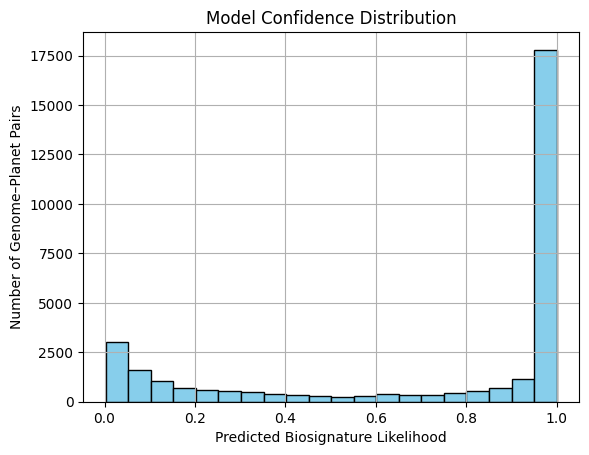

In [28]:
import matplotlib.pyplot as plt

probs = model.predict_proba(X_test)[:, 1]

plt.hist(probs, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Predicted Biosignature Likelihood")
plt.ylabel("Number of Genome–Planet Pairs")
plt.title("Model Confidence Distribution")
plt.grid(True)
plt.show()

In [30]:
# Predict biosignature match probabilities for all pairs
all_probs = model.predict_proba(X)[:, 1]

In [31]:
predictions = []
i = 0

for _, genome in genome_df.iterrows():
    for _, planet in planet_df.iterrows():
        predictions.append({
            "organism": genome["organism"],
            "gc_content": genome["gc_content"],
            "genome_size": genome["genome_size"],
            "planet": planet["planet_name"],
            "planet_temp": planet["equilibrium_temp"],
            "planet_radius": planet["radius_Earth"],
            "planet_mass": planet["mass_Earth"],
            "is_hot_adapted": genome["is_hot_adapted"],
            "is_cold_adapted": genome["is_cold_adapted"],
            "is_salt_adapted": genome["is_salt_adapted"],
            "predicted_likelihood": all_probs[i]
        })
        i += 1

predictions_df = pd.DataFrame(predictions)

In [32]:
top_matches = predictions_df.sort_values(by="predicted_likelihood", ascending=False).head(10)
top_matches[["organism", "planet", "predicted_likelihood", "is_hot_adapted", "planet_temp"]]

,organism,planet,predicted_likelihood,is_hot_adapted,planet_temp
112510,Halobacterium salinarum,KELT-9 b,1.0,0,5.369527
79554,Halobacterium salinarum,KELT-9 b,1.0,0,5.369527
128988,Halobacterium salinarum,KELT-9 b,1.0,0,5.369527
96032,Halobacterium salinarum,KELT-9 b,1.0,0,5.369527
114008,Halobacterium salinarum,KELT-9 b,1.0,0,5.369527
81052,Halobacterium salinarum,KELT-9 b,1.0,0,5.369527
100526,Halobacterium salinarum,KELT-9 b,1.0,0,5.369527
133482,Halobacterium salinarum,KELT-9 b,1.0,0,5.369527
136478,Halobacterium salinarum,KELT-9 b,1.0,0,5.369527
103522,Halobacterium salinarum,KELT-9 b,1.0,0,5.369527


In [34]:
predictions_df.to_csv("biosignature_predictions.csv", index=False)

In [36]:
from google.colab import drive
drive.mount('/content/drive')

# Save to your drive (change the path as needed)
predictions_df.to_csv("/content/drive/MyDrive/biosignature_predictions.csv", index=False)

Mounted at /content/drive


In [37]:
#These next sections will generate links to the unistellar app for each of the selected planets in the dataset.
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import pandas as pd

# Get planet names + RA/Dec
coords_df = NasaExoplanetArchive.query_criteria(
    table="pscomppars",
    select="pl_name,ra,dec",
    where="ra IS NOT NULL AND dec IS NOT NULL"
).to_pandas()

coords_df = coords_df.rename(columns={
    "pl_name": "planet",
    "ra": "ra_hours",
    "dec": "dec_degrees"
})
coords_df.head()

,planet,ra_hours,dec_degrees,sky_coord.ra,sky_coord.dec
0,OGLE-2016-BLG-1227L b,265.597125,-33.759778,265.597125,-33.759778
1,Kepler-24 e,290.413262,38.343728,290.413262,38.343728
2,Kepler-1065 b,294.511319,38.790465,294.511319,38.790465
3,HD 132406 b,224.227612,53.380961,224.227612,53.380961
4,TOI-1260 c,157.144071,65.854199,157.144071,65.854199


In [39]:
#now merge with the dataset
predictions_with_coords = predictions_df.merge(coords_df, on="planet", how="left")

In [42]:
#And finally gnereate the links.
def generate_unistellar_link(ra, dec):
    return f"unistellar://goto?ra={ra}&dec={dec}"

# Add column to DataFrame
predictions_with_coords["unistellar_link"] = predictions_with_coords.apply(
    lambda row: generate_unistellar_link(row["ra_hours"], row["dec_degrees"]),
    axis=1
)

In [47]:
# 📡 Setup for Exoplanet Predictions + Unistellar Telescope Links with QR Codes and Drive Export

# ✅ STEP 1: Install required libraries
!pip install astroquery qrcode[pil]

# ✅ STEP 2: Import Libraries
import pandas as pd
import qrcode
from IPython.display import display, Image
from io import BytesIO
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
from google.colab import drive

# ✅ STEP 3: Load Predictions CSV (make sure you've run your model first!)
try:
    predictions_df = pd.read_csv("biosignature_predictions.csv")
except FileNotFoundError:
    print("⚠️ File 'biosignature_predictions.csv' not found. Please generate and save predictions first.")
    predictions_df = pd.DataFrame()

# ✅ STEP 4: Get Coordinates from NASA (RA/Dec)
planet_df = NasaExoplanetArchive.query_criteria(
    table="pscomppars",
    select="pl_name,ra,dec",
    where="ra IS NOT NULL AND dec IS NOT NULL"
).to_pandas()

planet_df = planet_df.rename(columns={
    "pl_name": "planet",
    "ra": "ra_hours",
    "dec": "dec_degrees"
})

# ✅ STEP 5: Merge All Predictions with Coordinates
if not predictions_df.empty:
    all_predictions = predictions_df.merge(planet_df, on="planet", how="left")
    all_predictions = all_predictions.dropna(subset=["ra_hours", "dec_degrees"])
    all_predictions = all_predictions.sort_values(by="predicted_likelihood", ascending=False).reset_index(drop=True)
    all_predictions["unistellar_link"] = all_predictions.apply(
        lambda row: f"unistellar://goto?ra={row['ra_hours']}&dec={row['dec_degrees']}", axis=1
    )
    all_predictions["qr_code_link"] = all_predictions["unistellar_link"].apply(
        lambda link: f"https://api.qrserver.com/v1/create-qr-code/?size=150x150&data={link}"
    )

    # ✅ Preview Ranked Predictions
    display(all_predictions[[
        "organism", "planet", "predicted_likelihood", "ra_hours", "dec_degrees", "unistellar_link", "qr_code_link"
    ]].round({"predicted_likelihood": 3}))

    # ✅ Mount Google Drive and Export CSV
    drive.mount('/content/drive')
    output_path = "/content/drive/MyDrive/biosignature_predictions_with_links.csv"
    all_predictions.to_csv(output_path, index=False)
    print(f"📄 File saved to your Google Drive: {output_path}")

else:
    print("⚠️ No predictions available to merge with coordinates.")

,organism,planet,predicted_likelihood,ra_hours,dec_degrees,unistellar_link,qr_code_link
0,Halobacterium salinarum,KELT-9 b,1.000,307.859900,39.938916,unistellar://goto?ra=307.8598998&dec=39.9389161,https://api.qrserver.com/v1/create-qr-code/?si...
1,Halobacterium salinarum,KELT-9 b,1.000,307.859900,39.938916,unistellar://goto?ra=307.8598998&dec=39.9389161,https://api.qrserver.com/v1/create-qr-code/?si...
2,Halobacterium salinarum,KELT-9 b,1.000,307.859900,39.938916,unistellar://goto?ra=307.8598998&dec=39.9389161,https://api.qrserver.com/v1/create-qr-code/?si...
3,Halobacterium salinarum,KELT-9 b,1.000,307.859900,39.938916,unistellar://goto?ra=307.8598998&dec=39.9389161,https://api.qrserver.com/v1/create-qr-code/?si...
4,Halobacterium salinarum,KELT-9 b,1.000,307.859900,39.938916,unistellar://goto?ra=307.8598998&dec=39.9389161,https://api.qrserver.com/v1/create-qr-code/?si...
...,...,...,...,...,...,...,...
155787,Thermus thermophilus,OGLE-2005-BLG-390L b,0.003,268.579958,-30.377306,unistellar://goto?ra=268.579958&dec=-30.3773056,https://api.qrserver.com/v1/create-qr-code/?si...
155788,Thermus thermophilus,OGLE-2005-BLG-390L b,0.003,268.579958,-30.377306,unistellar://goto?ra=268.579958&dec=-30.3773056,https://api.qrserver.com/v1/create-qr-code/?si...
155789,Thermus thermophilus,OGLE-2005-BLG-390L b,0.003,268.579958,-30.377306,unistellar://goto?ra=268.579958&dec=-30.3773056,https://api.qrserver.com/v1/create-qr-code/?si...
155790,Thermus thermophilus,OGLE-2005-BLG-390L b,0.003,268.579958,-30.377306,unistellar://goto?ra=268.579958&dec=-30.3773056,https://api.qrserver.com/v1/create-qr-code/?si...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📄 File saved to your Google Drive: /content/drive/MyDrive/biosignature_predictions_with_links.csv
